# Cognitive Algorithms - Assignment 4
Cognitive Algorithms        
Winter Term 20/21      
Technische Universität Berlin     
Fachgebiet Maschinelles Lernen 
                    
**Respective quiz due on Januar 13, 2021 23:59 via ISIS**

**Answer the questions on Isis in 'Assignment 4 - Quiz' and copy code from this notebook where necessary.**

Programming
---

The application in this assignment is the same as in assignment 4. You will predict two dimensional hand positions $y \in \mathbb{R}^2$ from electromyographic (EMG) recordings $x \in \mathbb{R}^{192}$ obtained with high-density electrode arrays on the lower arm.     
Labels are 2D positions of the hand during different hand movements.

Remember that even after 'linearizing' the EMG-hand position relationship by computing the log of the EMG features, the relationship is not exactly linear. Also we do not know the exact non-linearity; it might not be the same for all regions in EMG space and for all electrodes. So we can hope to gain something from using a non-parametric and non-linear method like kernel ridge regression.

The criterion to evaluate the model and select optimal parameters is the so called coefficient of determination, or $r^2$ index
$$r^2 = 1-\frac{\sum_{d=1}^D \mathbb{V}(\hat{y}_d-y_d)}{\sum_{d=1}^D \mathbb{V}(y_d)}$$
where $D$ is the dimensionality of the data labels, $y$ are the true labels and $\hat{y}$ the estimated labels. This score is 1 for perfect predictions and smaller otherwise.

Use the data set ```myo_data.mat``` from the last assignment. 

In [1]:
import pylab as pl
import scipy as sp
from numpy.linalg import inv
from numpy.linalg import solve
from scipy.io import loadmat
import numpy as np
from scipy.spatial.distance import cdist
%matplotlib inline

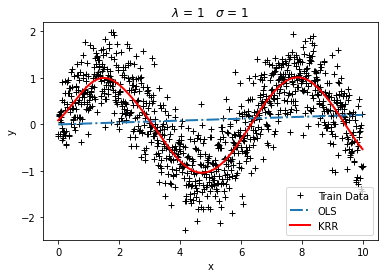

In [2]:
def load_data(fname):
    ''' Loads EMG data from <fname> '''
    # load the data
    data = loadmat(fname)
    # extract data for training
    X_train = data['training_data']
    X_train = np.log(X_train)
    X_train = X_train[:, :1000]
    # extract hand positions
    Y_train = data['training_labels']
    Y_train = Y_train[:, :1000]
    return X_train,Y_train

def GaussianKernel(X1, X2, kwidth):
    ''' Compute Gaussian Kernel 
    Input: X1     - DxN1 array of N1 data points with D features 
           X2     - DxN2 array of N2 data points with D features 
           kwidth - Kernel width
    Output K      - N1 x N2 Kernel matrix
    '''
    assert(X1.shape[0] == X2.shape[0])
    K = cdist(X1.T, X2.T, 'euclidean')
    K = np.exp(-(K ** 2) / (2. * kwidth ** 2))
    return K

def train_krr(X_train, Y_train, kwidth, llambda):
    ''' Trains kernel ridge regression (krr)
    Input:       X_train  -  DxN array of N data points with D features
                 Y        -  D2xN array of length N with D2 multiple labels
                 kwdith   -  kernel width
                 llambda  -  regularization parameter
    Output:      alphas   -  NxD2 array, weighting of training data used for apply_krr                     
    '''
    # YOUR CODE HERE
    K = GaussianKernel(X_train,X_train,kwidth)
    alphas = np.linalg.pinv(K+llambda*np.identity(len(K)))@Y_train.T
    return alphas


def apply_krr(alphas, X_train, X_test, kwidth):
    ''' Applys kernel ridge regression (krr)
    Input:      alphas      -  NtrxD2 array trained in train_krr      
                X_train     -  DxNtr array of Ntr train data points with D features
                X_test      -  DxNte array of Nte test data points with D features
                kwidht      -  Kernel width             
    Output:     Y_test      -  D2xNte array
    '''
    # YOUR CODE HERE
    k = GaussianKernel(X_train,X_test,kwidth)
    Y_test = alphas.T@k
#    print(alphas.shape)
#    print(X_test.shape)
#    print(X_train.shape)
#    print(Y_test.shape)
#    print(k.shape)
    return Y_test     # AUFPASSEN: Y_test[0] or Y_test ???

def train_ols(X_train, Y_train):
    ''' Trains ordinary least squares (ols) regression 
    Input:       X_train  -  DxN array of N data points with D features
                 Y        -  D2xN array of length N with D2 multiple labels
    Output:      W        -  DxD2 array, linear mapping used to estimate labels 
                             with np.dot(W.T, X)                      
    '''
    W = solve(X_train @ X_train.T, X_train @Y_train.T)
    return W
    
def apply_ols(W, X_test):
    ''' Applys ordinary least squares (ols) regression 
    Input:       X_test   -  DxN array of N data points with D features
                 W        -  DxD2 array, linear mapping used to estimate labels 
                             trained with train_ols                   
    Output:     Y_test    -  D2xN array
    '''
    Y_test = W.T @ X_test
    return Y_test

def test_handpositions():
    X,Y = load_data('myo_data.mat')
    crossvalidate_krr(X,Y)

def test_sine_toydata(kwidth = 1, llambda = 1):
    #Data generation
    X_train = np.arange(0,10,.01)
    X_train = X_train[None,:]
    Y_train = np.sin(X_train) + np.random.normal(0,.5,X_train.shape)
    #Linear Regression 
    w_est = train_ols(X_train, Y_train) 
    Y_est_lin = apply_ols(w_est,X_train)
    #Kernel Ridge Regression
    alphas = train_krr(X_train,Y_train,kwidth,llambda)
    Y_est_krr = apply_krr(alphas,X_train,X_train,kwidth)
    
    #Plot result
    pl.figure()
    pl.plot(X_train.T, Y_train.T, '+k', label = 'Train Data')
    pl.plot(X_train.T, Y_est_lin.T, '-.', linewidth = 2, label = 'OLS')
    pl.plot(X_train.T, Y_est_krr.T,  'r', linewidth = 2, label = 'KRR')
    pl.xlabel('x')
    pl.ylabel('y')
    pl.title(r'$\lambda$ = ' + str(llambda) + '   $\sigma$ = ' + str(kwidth))
    pl.legend(loc = 'lower right')
    
      
def crossvalidate_krr(X,Y,f=5, kwidths=10.0**np.array([0, 1, 2]), llambdas=10.0**np.array([-4, -2, 0])):
    ''' 
    Test generalization performance of kernel ridge regression with gaussian kernel
    Input:      X   data (dims-by-samples)
                Y   labels (dims2-by-samples)
                f   number of cross-validation folds
                kwidths width of gaussian kernel function 
                llambdas regularizer (height of ridge on kernel matrix)
    '''
    N = int(f*(X.shape[-1]/f))
    idx = np.reshape(np.random.permutation(np.arange(N)),(f,N//f))
    r2_outer = np.zeros((f))
    r2_linear = np.zeros((f))
    r2_inner = np.zeros((f-1,kwidths.shape[-1],llambdas.shape[-1]))
    
    # to outer cross-validation (model evaluation)
    for ofold in range(f):
        # split in training and test (outer fold)
        otestidx = np.zeros((f),dtype=bool)
        otestidx[ofold] = 1
        otest = idx[otestidx,:].flatten()
        otrain = idx[~otestidx,:]
        
        # inner cross-validation (model selection)
        for ifold in range(f-1):
            # split in training and test (inner fold)
            itestidx = np.zeros((f-1),dtype=bool)
            itestidx[ifold] = 1
            itest = otrain[itestidx,:].flatten()
            itrain = otrain[~itestidx,:].flatten()
            
            # do inner cross-validation (model selection)
            for illambda in range(llambdas.shape[-1]):
                for ikwidth in range(kwidths.shape[-1]):
                    #compute kernel for all data points
                    alphas = train_krr(X[:,itrain],Y[:,itrain],kwidths[ikwidth],llambdas[illambda])
                    yhat = apply_krr(alphas, X[:,itrain], X[:,itest],kwidths[ikwidth])
                    r2_inner[ifold,ikwidth,illambda] = compute_rsquare(yhat,Y[:,itest])

        #train again using optimal parameters
        r2_across_folds = r2_inner.mean(axis=0)
        optkwidthidx, optllambdaidx = np.unravel_index(r2_across_folds.flatten().argmax(),r2_across_folds.shape)
        #evaluate model on outer test fold
        alphas = train_krr(X[:,otrain.flatten()],Y[:,otrain.flatten()], kwidths[optkwidthidx],llambdas[optllambdaidx])
        yhat = apply_krr(alphas, X[:,otrain.flatten()],X[:,otest], kwidths[optkwidthidx])
        r2_outer[ofold] = compute_rsquare(yhat,Y[:,otest])

        # for comparison: predict with linear model
        w_est = train_ols(X[:,otrain.flatten()], Y[:,otrain.flatten()]) 
        y_est_lin = apply_ols(w_est,X[:,otest])
        r2_linear[ofold] = compute_rsquare(y_est_lin,Y[:,otest])
        
        print('Fold %d'%ofold + ' best kernel width %f'%kwidths[optkwidthidx] +\
        ' best regularizer %f'%llambdas[optllambdaidx] + \
        ' rsquare %f'%r2_outer[ofold] + \
        ' rsquare linear %f'%r2_linear[ofold])
    pl.figure()
    pl.boxplot(np.vstack((r2_outer,r2_linear)).T)
    pl.ylabel('$r^2$')
    pl.xticks((1,2),('KRR','Lin'))
    return r2_outer,r2_linear
    
def compute_rsquare(yhat,Y):
    '''compute coefficient of determination'''
    return 1 - (np.var((yhat - Y),axis=1).sum()/np.var(Y,axis=1).sum())

test_sine_toydata()

In [3]:
sp.random.seed(5)
X_train = np.random.rand(6,8)
X_test = np.random.rand(6,4)
Y = np.random.rand(1,8)
w = np.array([[-10.88806291],[-14.04762665],[  9.88494076],[ -6.68802798],[  3.54537817],[ -3.43169789],[  2.86056669],[ 19.34212098]])
Y_test = apply_krr(w, X_train, X_test, 10)
print(Y_test)

[[0.52063939 0.54835119 0.54108331 0.56645971]]


**A)** Implement Kernel Ridge Regression (KRR) by completing the function stubs  ```krr_train``` and  ```krr_apply```. 
We use the notation from assignment 3, 
$$X_{\text{train}} \in \mathbb{R}^{D_X \times N_{tr}}, \;  Y_{\text{train}} \in \mathbb{R}^{D_Y \times N_{tr}}, \; X_{\text{test}} \in \mathbb{R}^{D_X \times N_{te}}$$
In ```krr_train```, you estimate a linear combination of the input vectors $\alpha$, 
$$\alpha = (K + \lambda I)^{-1}Y_{\text{train}}^T$$
where $\lambda$ is the regularization parameter and $K$ is the $N_{tr} \times N_{tr}$ Gaussian Kernel matrix with Kernel width $\sigma$, $K_{ij} =  \exp\left( - \frac{\| X_{\text{train}}^i - X_{\text{train}}^j\|^2}{\sigma^2} \right)$. You can compute $K$ with the provided function ```GaussianKernel```.

The function ```krr_apply``` than uses the weights $\alpha$ to predict the (unknown) hand positions of new test data $X_{\text{test}}$
$$Y_{\text{test}} = (\mathbf{k} \alpha)^T.$$
where $\mathbf k$ is the $N_{\text{test}} \times N_{\text{train}}$ matrix $\mathbf{k}_{ij} =   \exp\left( - \frac{\| X_{\text{test}}^i - X_{\text{train}}^j\|^2}{\sigma^2}\right)$.    

The function  ```test_sine_toydata``` helps you to debug your code. It generates toy data that follows a sine function, $x_i \in \{0, 0.01, 0.02, \ldots, 10\}, y_i = \sin(x_i) + \epsilon, \epsilon \sim \mathcal{N}(0, 0.5)$. The result of KRR should resemble the sine function.

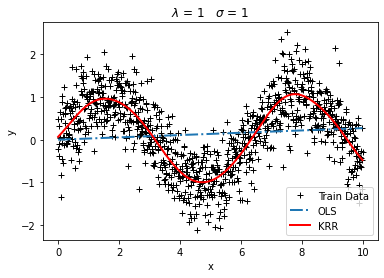

In [4]:
test_sine_toydata()

**B)** We want to analyse how the Kernel Ridge solution depends on its hyperparameters, the kernel width $\sigma$ and  the regularization parameter $\lambda$. 
- Call the function  ```test_sine_toydata```  with $\lambda$ = 1 for three different Kernel widths, $\sigma = \{ 0.1, 1, 10\}$.
- Call the function  ```test_sine_toydata```  with $\sigma$ = 1 for three different regularization parameters, $\lambda = \{ 10^{-10}, 1, 500\}$. 

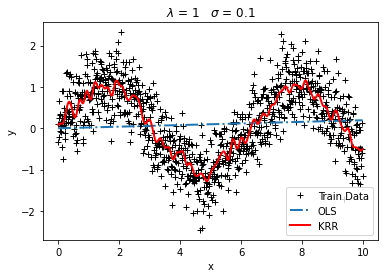

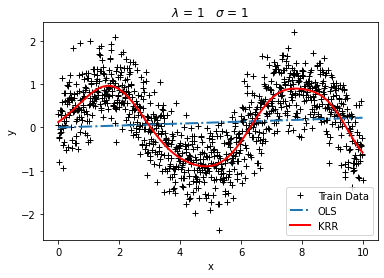

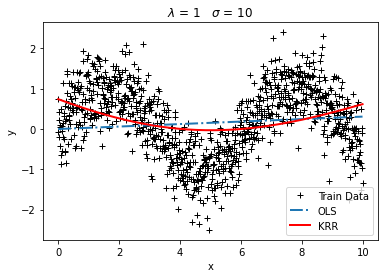

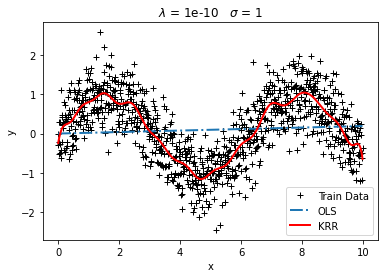

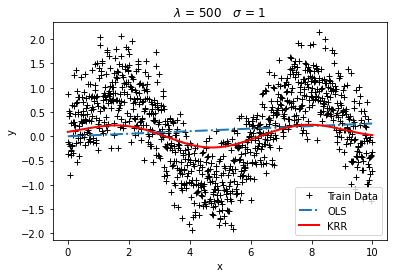

In [5]:
test_sine_toydata(kwidth = 0.1, llambda = 1)
test_sine_toydata(kwidth = 1, llambda = 1)
test_sine_toydata(kwidth = 10, llambda = 1)
test_sine_toydata(kwidth = 1, llambda = 1e-10)
test_sine_toydata(kwidth = 1, llambda = 500)

**C)** Predict two dimensional hand positions with Kernel Ridge Regression by calling the function ``` test_handpositions```. It shows a boxplot for the linear regression and the Kernel Ridge Regression.

Fold 0 best kernel width 10.000000 best regularizer 0.010000 rsquare 0.953564 rsquare linear 0.920775
Fold 1 best kernel width 10.000000 best regularizer 0.000100 rsquare 0.951418 rsquare linear 0.920047
Fold 2 best kernel width 10.000000 best regularizer 0.010000 rsquare 0.961311 rsquare linear 0.915884
Fold 3 best kernel width 10.000000 best regularizer 0.010000 rsquare 0.956342 rsquare linear 0.915876
Fold 4 best kernel width 10.000000 best regularizer 0.010000 rsquare 0.960548 rsquare linear 0.926635


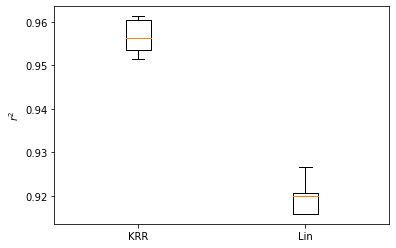

In [6]:
test_handpositions()

# Cognitive Algorithms - Assignment 4 - Exercise4

In [7]:
# Data Points
x1 = np.array([1])
x2 = np.array([2])
x3 = np.array([3])
#x4 = np.array([4])                  # test for 4 points
X1 = np.column_stack((x1,x2,x3))
#X1 = np.column_stack((x1,x2,x3,x4)) # test for 4 points

# Feature space
phi = [[0],[1],[2]]                  # x --> 1, x, x^2
phifunc = lambda X,phi: X**phi       # x --> 1, x, x^2
X2 = phifunc(X1,phi)
print(f'X1:\n{X1}')
print(f'X2:\n{X2}')

# Labels
y1 = 1
y2 = 1
y3 = 1
#y4 = 1                              # test for 4 points
y = np.array([y1,y2,y3])
#y = np.array([y1,y2,y3,y4])         # test for 4 points

# Parameters
lambd = 0.0001
sigma1 = 2**(1/2)
sigma2 = 2**(-1/2)

# Functions
kernelfunc = lambda x1,x2,phifunc: phifunc(x1,phi).T@phifunc(x2,phi)
kernelfunc_RBF = lambda x1,x2,sigma: np.exp(-(x1-x2)**2/(2*sigma**2))
alphafunc = lambda K,y: np.linalg.pinv(K + lambd*np.identity(len(K)))@y.T

X1:
[[1 2 3]]
X2:
[[1 1 1]
 [1 2 3]
 [1 4 9]]


In [8]:
# (1) Ridge Regression - g = w * x
w1 = np.linalg.pinv(X1@X1.T + lambd*np.identity(len(x1)))@X1@y.T
g1 = lambda x,w: w*x
print(f'w1: {np.round(w1,2)}')

w1: [0.43]


In [9]:
# (2) Ridge Regression - g = w1 + w2 * x + w3 * x^2
w2 = np.linalg.pinv(X2@X2.T + lambd*np.identity(len(X2)))@X2@y.T
g2 = lambda x,w: w.T@phifunc(np.array([x]),phi)
print(f'w2: {np.round(w2,2)}')

w2: [ 1.  0. -0.]


In [10]:
# (3) Kernel Ridge Regression - g = sum(alpha_i * k (x_i, x_new))
K3 = kernelfunc(X1,X1,phifunc)
alpha3 = alphafunc(K3,y)
g3 = lambda x,alpha: [np.sum(alpha@kernelfunc(X1,np.array([xi]),phifunc),axis=0) for xi in x]
print(f'alpha:{np.round(alpha3,2)}')
print(f'K:\n{K3}')

alpha:[ 2.99 -2.99  0.99]
K:
[[ 3  7 13]
 [ 7 21 43]
 [13 43 91]]


In [11]:
# (4) Kernel Ridge Regression - RBF-Kernel sigma=2^(1/2)
K_RBF1 = kernelfunc_RBF(X1.T,X1,sigma1)
K_RBF2 = kernelfunc_RBF(X1.T,X1,sigma2)
alpha_RBF1 = alphafunc(K_RBF1,y)
alpha_RBF2 = alphafunc(K_RBF2,y)
g4 = lambda x,alpha,sigma: [np.sum(alpha@kernelfunc_RBF(X1,np.array([xi]),sigma).T,axis=0) for xi in x]
print(f'alpha_RBF1:{np.round(alpha_RBF1,2)}')
print(f'K_RBF1:\n{K_RBF1}')
print('\n')
print(f'alpha_RBF2:{np.round(alpha_RBF2,2)}')
print(f'K_RBF2:\n{K_RBF2}')

alpha_RBF1:[ 1.43 -1.22  1.43]
K_RBF1:
[[1.         0.77880078 0.36787944]
 [0.77880078 1.         0.77880078]
 [0.36787944 0.77880078 1.        ]]


alpha_RBF2:[0.85 0.38 0.85]
K_RBF2:
[[1.         0.36787944 0.01831564]
 [0.36787944 1.         0.36787944]
 [0.01831564 0.36787944 1.        ]]


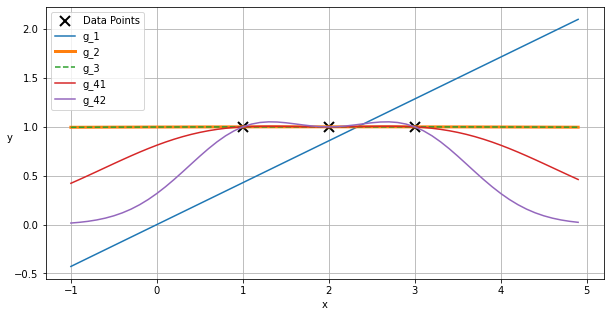

In [12]:
pl.figure(1,figsize=(10,5))
x = np.arange(-1,5,0.1)
pl.plot(X1[0],y,'kx',ms=10,mew=2,label='Data Points')
pl.plot(x,g1(x,w1),label='g_1')
pl.plot(x,g2(x,w2),lw=3,label='g_2')
pl.plot(x,g3(x,alpha3),'--',label='g_3')
pl.plot(x,g4(x,alpha_RBF1,sigma1),label='g_41')
pl.plot(x,g4(x,alpha_RBF2,sigma2),label='g_42')
pl.xlabel('x')
pl.ylabel('y',rotation=0)
pl.legend(loc = 'upper left');
pl.grid(True)